In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import xarray as xr
import rioxarray
from rioxarray.merge import merge_arrays
import xdem
import tempfile
from pysheds.grid import Grid
import numpy as np
from matplotlib import colors
import seaborn as sns

current_path = Path.cwd().parent
print(current_path)

/home/nissim/Documents/dev/ciut-inundaciones


In [2]:
dat = gpd.read_parquet(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023.parquet"
)
# dat.to_file("/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023.geojson", driver="GeoJSON")

In [3]:
dat.head()

ID      H      V    H*V       PELIGROSID  \
0  2500.0  1.573  0.101  0.159             alta   
1  1130.0  0.492  0.233  0.115             baja   
2     1.0  0.081  0.038  0.003  Muy Baja a Nula   
3  1224.0  0.511  0.196  0.100            media   
4     NaN  1.524  0.193  0.294             alta   

                                            geometry      fid  Hmax  Vmax  id  
0  MULTIPOLYGON (((6391904.396 6107035.374, 63919...      NaN   NaN   NaN NaN  
1  MULTIPOLYGON (((6389934.396 6110755.374, 63899...      NaN   NaN   NaN NaN  
2  MULTIPOLYGON (((6392224.396 6106475.374, 63922...      NaN   NaN   NaN NaN  
3  MULTIPOLYGON (((6388694.396 6112655.374, 63887...      NaN   NaN   NaN NaN  
4  MULTIPOLYGON (((6403735.226 6095243.957, 64037...  10180.0   NaN   NaN NaN

In [4]:
el_gato_path = current_path / "data/c_el_gato_peli_alta_2023.parquet"
el_gato_gdf = gpd.read_parquet(el_gato_path)

In [5]:
# create a bounding box of the el gato gdf and use it to clip the dat gdf
el_gato_bbox = el_gato_gdf.total_bounds
el_gato_full = dat.clip(el_gato_bbox)

In [7]:
el_gato_alta = el_gato_full[el_gato_full["PELIGROSID"] == "alta"]
el_gato_media = el_gato_full[el_gato_full["PELIGROSID"] == "media"]
el_gato_baja = el_gato_full[el_gato_full["PELIGROSID"] == "baja"]

In [8]:
el_gato_alta.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/el_gato_alta.geojson",
    driver="GeoJSON",
)
el_gato_media.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/el_gato_media.geojson",
    driver="GeoJSON",
)
el_gato_baja.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/el_gato_baja.geojson",
    driver="GeoJSON",
)

<Axes: >

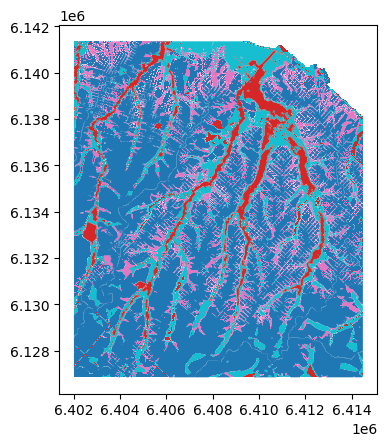

In [6]:
el_gato_full.plot("PELIGROSID")

In [9]:
gdf_high = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/smoothing_tests/el_gato_alta_smooth_2.5m_buffer/el_gato_alta_smooth_2.5m_buffer_clean.geojson"
)
gdf_medium = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/smoothing_tests/el_gato_media_smooth_2.5m_buffer/el_gato_media_smooth_2.5m_buffer_clean.geojson"
)
gdf_low = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/smoothing_tests/el_gato_baja_smooth_2.5m_buffer/el_gato_baja_smooth_2.5m_buffer_clean.geojson"
)

In [10]:
gdf_high.head()

cat    id     h     v    h_v peligrosid   fid   hmax   vmax  id_1  \
0    1  None  None  None  0.193       alta  None  1.533  0.126  None   
1    1  None  None  None  0.193       alta  None  1.533  0.126  None   
2    1  None  None  None  0.193       alta  None  1.533  0.126  None   
3    1  None  None  None  0.193       alta  None  1.533  0.126  None   
4    1  None  None  None  0.193       alta  None  1.533  0.126  None   

                                            geometry  
0  POLYGON ((6412673.15 6129015.36, 6412668.15 61...  
1  POLYGON ((6414378.15 6132575.36, 6414383.15 61...  
2  POLYGON ((6414105.75 6136322.95, 6414105.75 61...  
3  POLYGON ((6404505.16 6132668.1, 6404505.16 613...  
4  POLYGON ((6409525.16 6133238.1, 6409525.16 613...

In [11]:
# Step 1: Dissolve each by hazard to simplify
high_union = gdf_high.dissolve(by="peligrosid")
medium_union = gdf_medium.dissolve(by="peligrosid")
low_union = gdf_low.dissolve(by="peligrosid")

In [12]:
# Step 2: Remove overlaps according to priority
# Clip medium to remove high
medium_diff = medium_union.difference(high_union.unary_union)

# Clip low to remove both high and medium
low_diff = low_union.difference(high_union.unary_union.union(medium_union.unary_union))

/tmp/ipykernel_115715/4174591899.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  medium_diff = medium_union.difference(high_union.unary_union)
/tmp/ipykernel_115715/4174591899.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  low_diff = low_union.difference(high_union.unary_union.union(medium_union.unary_union))


In [13]:
# Step 3: Build final GeoDataFrame
gdf_high_final = gpd.GeoDataFrame(geometry=[high_union.unary_union], crs=gdf_high.crs)
gdf_high_final["peligrosid"] = "alta"

gdf_medium_final = gpd.GeoDataFrame(
    geometry=[medium_diff.unary_union], crs=gdf_medium.crs
)
gdf_medium_final["peligrosid"] = "media"

gdf_low_final = gpd.GeoDataFrame(geometry=[low_diff.unary_union], crs=gdf_low.crs)
gdf_low_final["peligrosid"] = "baja"

# Combine all
combined = gpd.GeoDataFrame(
    pd.concat([gdf_high_final, gdf_medium_final, gdf_low_final], ignore_index=True),
    crs=gdf_high.crs,
)

/tmp/ipykernel_115715/1421402798.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_high_final = gpd.GeoDataFrame(geometry=[high_union.unary_union], crs=gdf_high.crs)
/tmp/ipykernel_115715/1421402798.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_medium_final = gpd.GeoDataFrame(geometry=[medium_diff.unary_union], crs=gdf_medium.crs)
/tmp/ipykernel_115715/1421402798.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_low_final = gpd.GeoDataFrame(geometry=[low_diff.unary_union], crs=gdf_low.crs)


<Axes: >

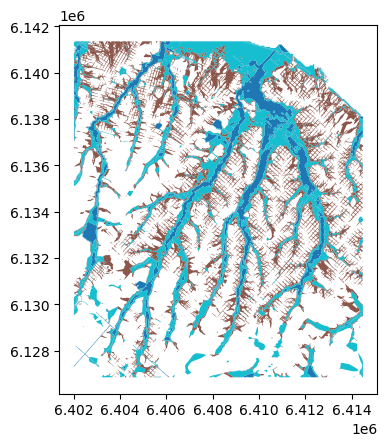

In [14]:
combined.plot("peligrosid")

In [17]:
combined = combined.to_crs(epsg=4326)


# Export
combined.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/combined_hazard_prioritized_4326.geojson",
    driver="GeoJSON",
)

In [18]:
# Export
combined.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/combined_hazard_prioritized_4326.geojson",
    driver="GeoJSON",
)

## Combine Original Data for PMTIles

In [4]:
gdf_high.head()

ID     H     V    H*V PELIGROSID   fid   Hmax   Vmax    id  \
0      NaN  None  None  0.193       alta  None  1.533  0.126  None   
1  13301.0  None  None  0.434       alta  None  1.503  0.289  None   
2   8151.0  None  None  1.581       alta  None  0.938  1.686  None   
3   4829.0  None  None  0.572       alta  None  2.030  0.282  None   
4  22437.0  None  None  0.248       alta  None  1.520  0.163  None   

                                            geometry  
0  MULTIPOLYGON (((6412075.219 6127015.259, 64120...  
1  MULTIPOLYGON (((6413145.65 6128525.36, 6413145...  
2  MULTIPOLYGON (((6413935.75 6135415.45, 6413935...  
3  MULTIPOLYGON (((6405785.16 6127125.6, 6405785....  
4  MULTIPOLYGON (((6402045.07 6129755.71, 6402045...

In [5]:
gdf_high = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/el_gato_alta.geojson"
)
gdf_medium = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/el_gato_media.geojson"
)
gdf_low = gpd.read_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/el_gato_baja.geojson"
)
# Step 1: Dissolve each by hazard to simplify
high_union = gdf_high.dissolve(by="PELIGROSID")
medium_union = gdf_medium.dissolve(by="PELIGROSID")
low_union = gdf_low.dissolve(by="PELIGROSID")

# Step 2: Remove overlaps according to priority
# Clip medium to remove high
medium_diff = medium_union.difference(high_union.unary_union)

# Clip low to remove both high and medium
low_diff = low_union.difference(high_union.unary_union.union(medium_union.unary_union))

# Step 3: Build final GeoDataFrame
gdf_high_final = gpd.GeoDataFrame(geometry=[high_union.unary_union], crs=gdf_high.crs)
gdf_high_final["peligrosid"] = "alta"

gdf_medium_final = gpd.GeoDataFrame(
    geometry=[medium_diff.unary_union], crs=gdf_medium.crs
)
gdf_medium_final["peligrosid"] = "media"

gdf_low_final = gpd.GeoDataFrame(geometry=[low_diff.unary_union], crs=gdf_low.crs)
gdf_low_final["peligrosid"] = "baja"

# Combine all
combined = gpd.GeoDataFrame(
    pd.concat([gdf_high_final, gdf_medium_final, gdf_low_final], ignore_index=True),
    crs=gdf_high.crs,
)

combined = combined.to_crs(epsg=4326)

# Export
combined.to_file(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/combined_hazard_original_4326.geojson",
    driver="GeoJSON",
)

/tmp/ipykernel_58391/2596720834.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  medium_diff = medium_union.difference(high_union.unary_union)
/tmp/ipykernel_58391/2596720834.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  low_diff = low_union.difference(high_union.unary_union.union(medium_union.unary_union))
/tmp/ipykernel_58391/2596720834.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_high_final = gpd.GeoDataFrame(geometry=[high_union.unary_union], crs=gdf_high.crs)
/tmp/ipykernel_58391/2596720834.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_medium_final = gpd.GeoDataFrame(geometry=[medium_diff.unary_union], crs=gdf_medium.crs)
/tmp/ipykernel_58391/2596720834.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, u

### Scratch

In [3]:
el_gato_gdf.crs

<Projected CRS: EPSG:5348>
Name: POSGAR 2007 / Argentina 6
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Argentina - between 58°30'W and 55°30'W, onshore.
- bounds: (-58.5, -38.59, -55.49, -24.84)
Coordinate Operation:
- name: Argentina zone 6
- method: Transverse Mercator
Datum: Posiciones Geodesicas Argentinas 2007
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

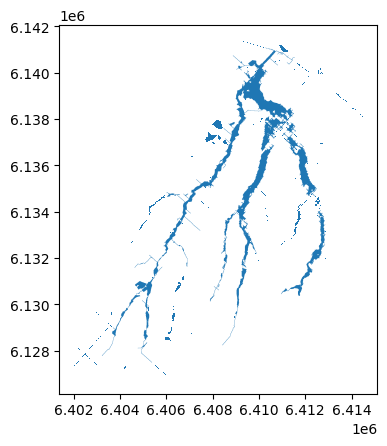

In [4]:
el_gato_gdf.plot()

In [5]:
# convert to epsg:4326
el_gato_gdf = el_gato_gdf.to_crs(epsg=4326)

# get the bbox of the el gato gdf
el_gato_bbox = el_gato_gdf.total_bounds

# load pystac client
# check for fabdem access (may need GEE authentication)
# get bbox of data (likely will need to reconcile CRS)
# query for fabdem data using xarray
# plot using viridis with maybe an exponential color map or somethig to avoid extremes
# see if I can use whitebox for processing

In [7]:
# Load and merge the tiles
tile_paths = [
    current_path / "data/S40W060-S30W050_FABDEM_V1-2/S35W058_FABDEM_V1-2.tif",
    current_path / "data/S40W060-S30W050_FABDEM_V1-2/S36W058_FABDEM_V1-2.tif",
    current_path / "data/S40W060-S30W050_FABDEM_V1-2/S35W059_FABDEM_V1-2.tif",
    current_path / "data/S40W060-S30W050_FABDEM_V1-2/S36W059_FABDEM_V1-2.tif",
]

tiles = [rioxarray.open_rasterio(path) for path in tile_paths]
merged_dem = merge_arrays(tiles)

# Clip to bounding box
clipped_dem = merged_dem.rio.clip_box(
    minx=el_gato_bbox[0],
    miny=el_gato_bbox[1],
    maxx=el_gato_bbox[2],
    maxy=el_gato_bbox[3],
)

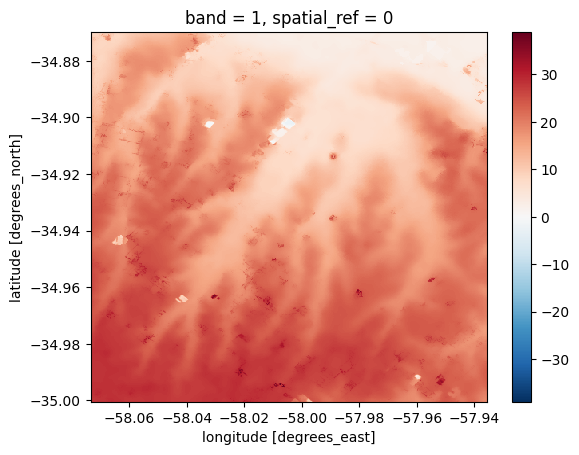

In [8]:
clipped_dem.plot()

## XDEM

In [88]:
# Save xarray to temporary GeoTIFF file WITHOUT nodata
with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmp_file:
    temp_path = tmp_file.name

# Use rioxarray to save the xarray as a GeoTIFF WITHOUT nodata
clipped_dem.rio.to_raster(temp_path)

# Reproject to UTM Zone 20S before saving
# Reproject with explicit equal resolution
reprojected_dem = clipped_dem.rio.reproject(
    "EPSG:32720",
    resolution=30,  # Set explicit 30m resolution
)
# Then save the reprojected DEM to temp file
reprojected_dem.rio.to_raster(temp_path)

In [89]:
dem = xdem.DEM(temp_path)

In [90]:
dem.res

(30.0, 30.0)

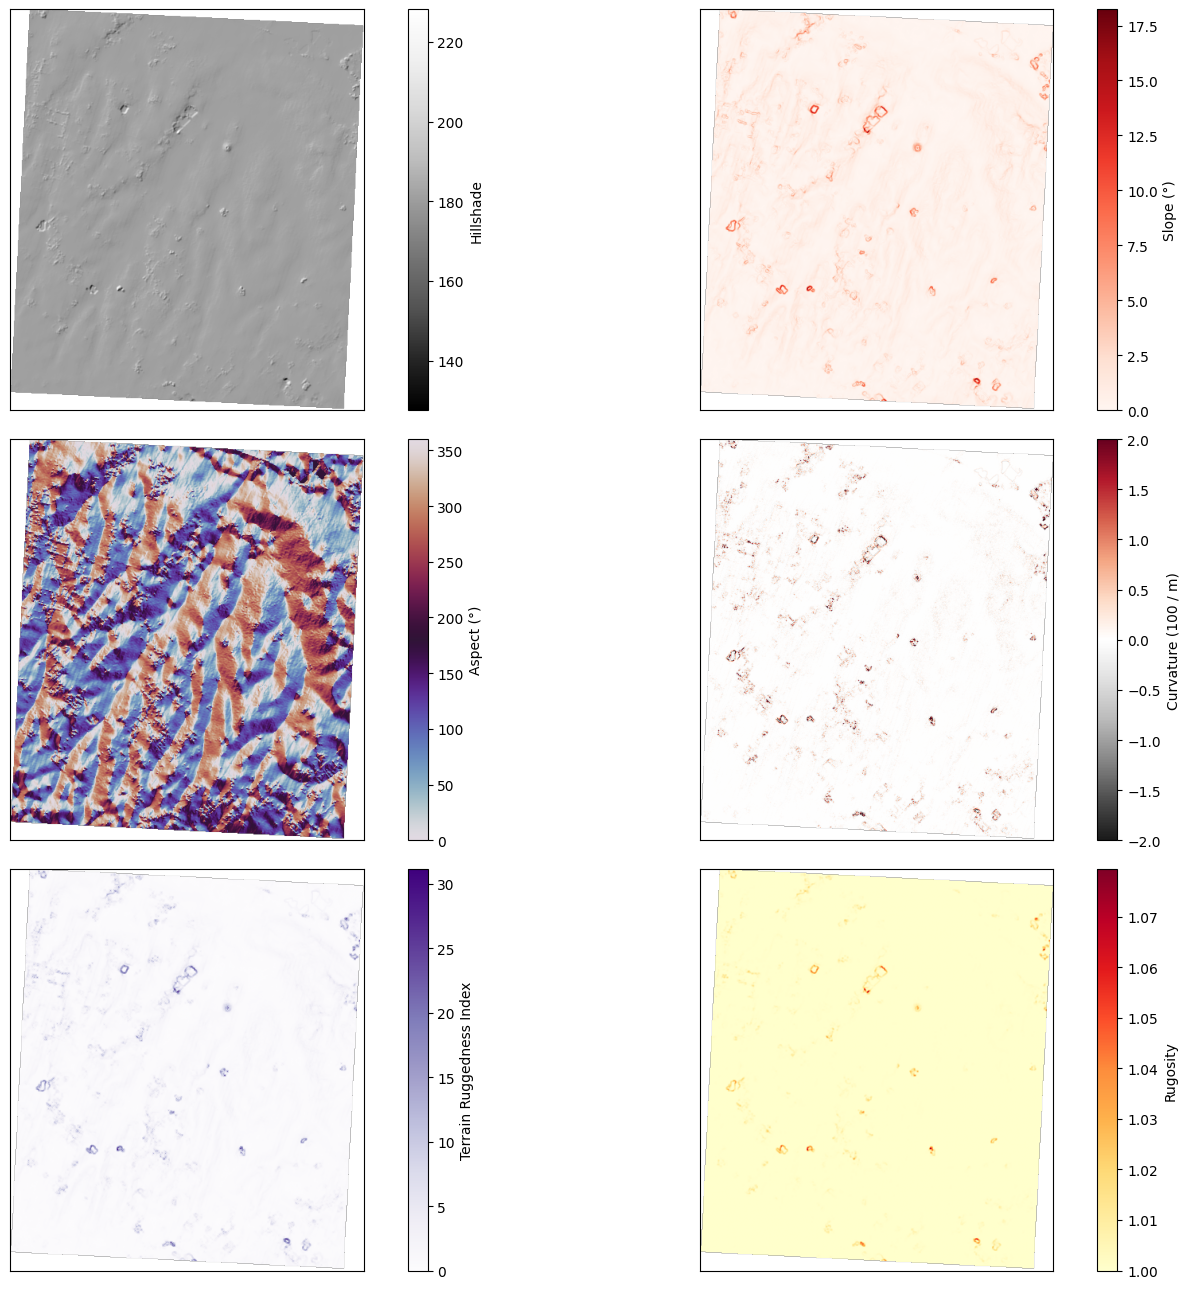

In [ ]:
attributes = xdem.terrain.get_terrain_attribute(
    dem.data,
    resolution=dem.res,
    attribute=[
        "hillshade",
        "slope",
        "aspect",
        "curvature",
        "terrain_ruggedness_index",
        "rugosity",
    ],
)

plt.figure(figsize=(8 * 2, 6.5 * 2))

plt_extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]

cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd"]
labels = [
    "Hillshade",
    "Slope (°)",
    "Aspect (°)",
    "Curvature (100 / m)",
    "Terrain Ruggedness Index",
    "Rugosity",
]
vlims = [(None, None) for i in range(6)]
vlims[3] = [-2, 2]

for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.imshow(
        attributes[i].squeeze(),
        cmap=cmaps[i],
        extent=plt_extent,
        vmin=vlims[i][0],
        vmax=vlims[i][1],
    )
    cbar = plt.colorbar()
    cbar.set_label(labels[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [97]:
# For each terrain attribute, create a new DEM object and save it
attribute_names = ["slope"]

for i, (attr_name, attr_data) in enumerate(zip(attribute_names, attributes)):
    # Create new DEM object with same geospatial properties as original DEM
    new_dem = xdem.DEM.from_array(attr_data, transform=dem.transform, crs=dem.crs)
    # Save to file
    new_dem.save(f"{attr_name}.tif")

/home/nissim/Documents/dev/ciut-inundaciones/.venv/lib/python3.12/site-packages/geoutils/raster/raster.py:1748: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


In [99]:
# Get slope data (index 1 in the attributes list)
slope_data = attributes[1]  # slope is the second attribute

# Create coordinates from DEM bounds and resolution
y_coords = np.arange(dem.bounds.bottom, dem.bounds.top, dem.res[1])
x_coords = np.arange(dem.bounds.left, dem.bounds.right, dem.res[0])

# Create xarray DataArray
slope_xarray = xr.DataArray(
    slope_data,
    coords={"y": y_coords, "x": x_coords},
    dims=["y", "x"],
    attrs={"crs": dem.crs, "units": "degrees", "long_name": "slope"},
)

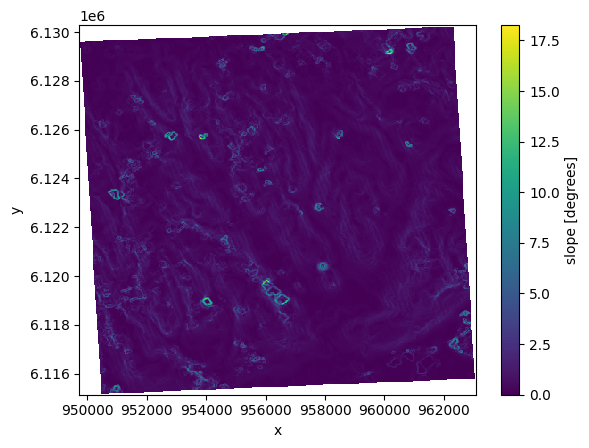

In [101]:
slope_xarray.plot()

## PySheds

In [60]:
# Check if there are any nodata values in the actual data
nodata_value = clipped_dem.attrs.get("_FillValue", -9999.0)

# Check if nodata values exist in the data
if nodata_value in clipped_dem.values:
    print(f"  Found {np.sum(clipped_dem.values == nodata_value)} nodata cells")
else:
    print("  No nodata values found in data")

  No nodata values found in data


In [64]:
# Save xarray to temporary GeoTIFF file WITHOUT nodata
with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmp_file:
    temp_path = tmp_file.name

# Use rioxarray to save the xarray as a GeoTIFF WITHOUT nodata
clipped_dem.rio.to_raster(temp_path)

# Now use pysheds with the temporary file


grid = Grid.from_raster(temp_path)

# Load the DEM data into the grid WITHOUT specifying nodata
dem = grid.read_raster(temp_path)

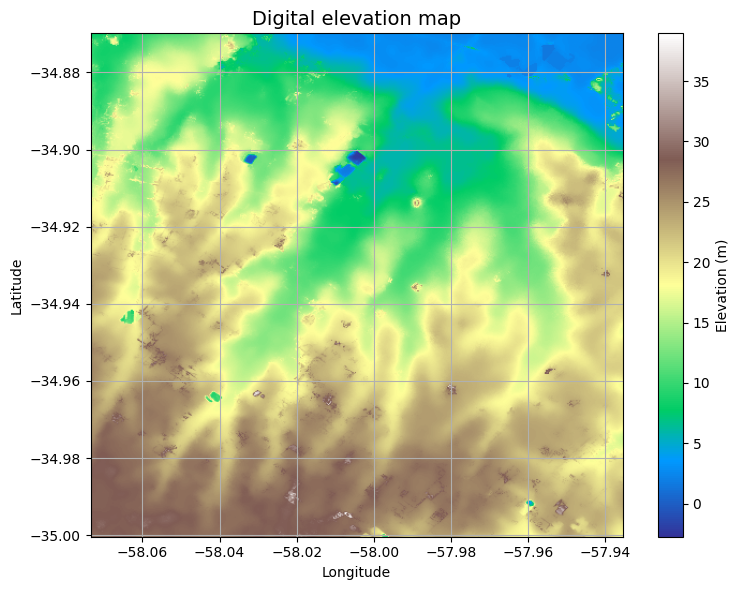

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(clipped_dem.values[0], extent=grid.extent, cmap="terrain", zorder=1)
plt.colorbar(label="Elevation (m)")
plt.grid(zorder=0)
plt.title("Digital elevation map", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

In [66]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [67]:
# Convert pysheds Raster to xarray DataArray
inflated_dem_xarray = xr.DataArray(
    inflated_dem,
    coords={"y": clipped_dem.y, "x": clipped_dem.x},
    dims=["y", "x"],
    attrs=clipped_dem.attrs,
)

# Set the CRS
inflated_dem_xarray.rio.write_crs("EPSG:4326", inplace=True)

# Write to GeoTIFF using rioxarray
inflated_dem_xarray.rio.to_raster(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/inflated_dem.tif"
)

In [32]:
# Save xarray to temporary GeoTIFF file
with tempfile.NamedTemporaryFile(suffix=".tif", delete=False) as tmp_file:
    temp_path = tmp_file.name

# Use rioxarray to save the xarray as a GeoTIFF
clipped_dem.rio.to_raster(temp_path)

# Now use pysheds with the temporary file

grid = Grid.from_raster(temp_path)

# Load the DEM data into the grid
dem = grid.read_raster(temp_path)

# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions with explicit nodata_out
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap, nodata_out=np.int32(0))

# Clean up the temporary file when done
Path(temp_path).unlink()

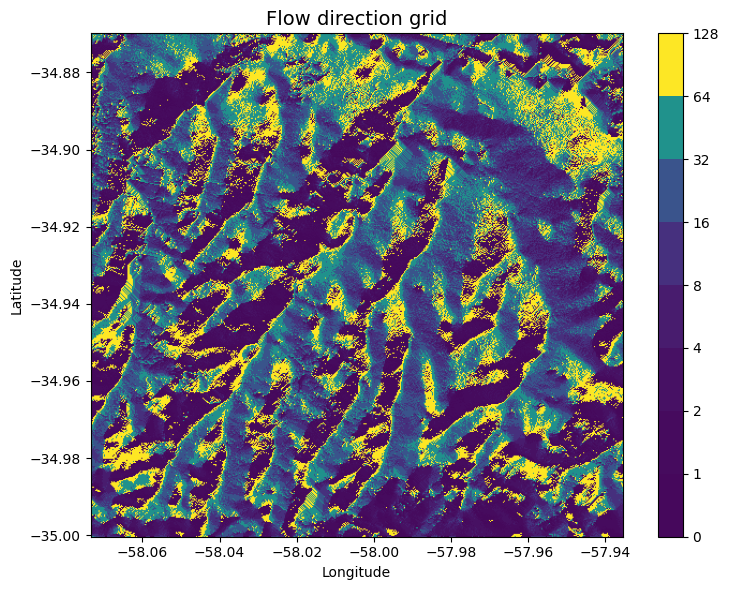

In [33]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap="viridis", zorder=2)
boundaries = [0] + sorted(list(dirmap))
plt.colorbar(boundaries=boundaries, values=sorted(dirmap))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Flow direction grid", size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [49]:
# Convert pysheds Raster to xarray DataArray
fdir_xarray = xr.DataArray(
    fdir,
    coords={"y": clipped_dem.y, "x": clipped_dem.x},
    dims=["y", "x"],
    attrs=clipped_dem.attrs,
)

# Set the CRS
fdir_xarray.rio.write_crs("EPSG:4326", inplace=True)

# Write to GeoTIFF using rioxarray
fdir_xarray.rio.to_raster(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/flow_direction.tif"
)

In [35]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap, nodata_out=np.int32(0))

In [48]:
# Convert pysheds Raster to xarray DataArray
acc_xarray = xr.DataArray(
    acc,
    coords={"y": clipped_dem.y, "x": clipped_dem.x},
    dims=["y", "x"],
    attrs=clipped_dem.attrs,
)

# Set the CRS
acc_xarray.rio.write_crs("EPSG:4326", inplace=True)

# Write to GeoTIFF using rioxarray
acc_xarray.rio.to_raster(
    "/home/nissim/Documents/dev/ciut-inundaciones/data/flow_accumulation.tif"
)

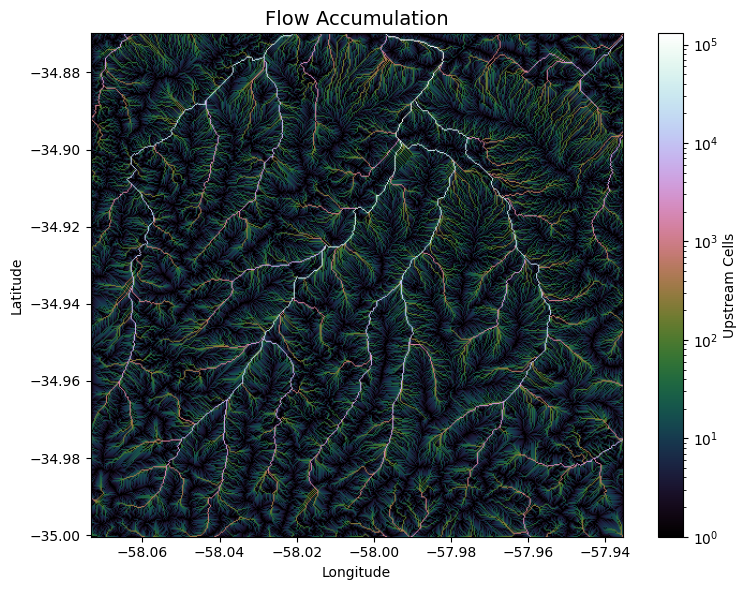

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid("on", zorder=0)
im = ax.imshow(
    acc,
    extent=grid.extent,
    zorder=2,
    cmap="cubehelix",
    norm=colors.LogNorm(1, acc.max()),
    interpolation="bilinear",
)
plt.colorbar(im, ax=ax, label="Upstream Cells")
plt.title("Flow Accumulation", size=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

In [69]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc > 200, nodata_value=np.int32(0))

TypeError: `nodata` value not representable in dtype of array.

In [ ]:
# Create a view of HAND in the catchment
hand_view = grid.view(hand, nodata=np.nan)

In [43]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(
    fdir, acc > 50, dirmap=dirmap, nodata_val=np.int32(0)
)

TypeError: `nodata` value not representable in dtype of array.

In [ ]:
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(8.5, 6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect("equal")

for branch in branches["features"]:
    line = np.asarray(branch["geometry"]["coordinates"])
    plt.plot(line[:, 0], line[:, 1])

_ = plt.title("D8 channels", size=14)

## Topographic Wetness Index

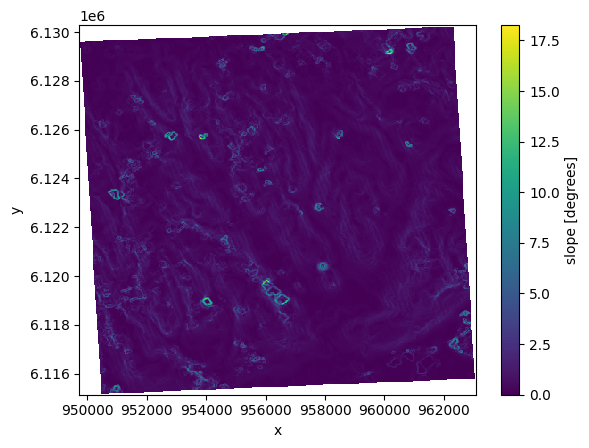

In [102]:
slope_xarray.plot()

In [105]:
slope_xarray

<xarray.DataArray (y: 505, x: 445)> Size: 899kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(505, 445), dtype=float32)
Coordinates:
  * y        (y) float64 4kB 6.115e+06 6.115e+06 6.115e+06 ... 6.13e+06 6.13e+06
  * x        (x) float64 4kB 9.497e+05 9.498e+05 ... 9.63e+05 9.631e+05
Attributes:
    crs:        EPSG:32720
    units:      degrees
    long_name:  slope

In [109]:
# Reproject acc_xarray from EPSG:4326 to EPSG:32720 to match slope_xarray
acc_xarray_reprojected = acc_xarray.rio.reproject("EPSG:32720")

# Verify both arrays now have the same CRS
print(f"acc_xarray CRS: {acc_xarray_reprojected.rio.crs}")
print(f"slope_xarray CRS: {slope_xarray.rio.crs}")

# Now both arrays should be in the same coordinate system (EPSG:32720)

acc_xarray CRS: EPSG:32720
slope_xarray CRS: EPSG:32720


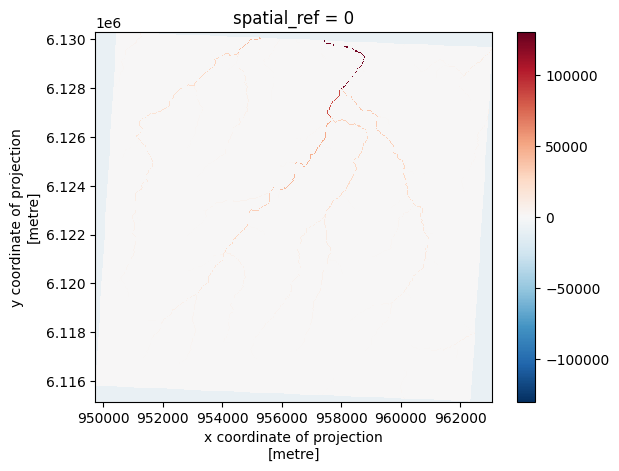

In [110]:
acc_xarray_reprojected.plot()

In [112]:
# First, let's check the shapes
print(f"acc_xarray_reprojected shape: {acc_xarray_reprojected.shape}")
print(f"slope_xarray shape: {slope_xarray.shape}")

acc_xarray_reprojected shape: (538, 474)
slope_xarray shape: (505, 445)


In [114]:
# First, let's resample slope_xarray to match acc_xarray_reprojected
slope_resampled = slope_xarray.rio.reproject(
    acc_xarray_reprojected.rio.crs,
    shape=acc_xarray_reprojected.shape,
    transform=acc_xarray_reprojected.rio.transform(),
)

# Now both arrays should have the same shape
print(f"slope_resampled shape: {slope_resampled.shape}")
print(f"acc_xarray_reprojected shape: {acc_xarray_reprojected.shape}")

# Then perform the TWI calculation
slope_rad = np.radians(slope_resampled) + 0.0001
twi_data = np.log(acc_xarray_reprojected / np.tan(slope_rad))

slope_resampled shape: (538, 474)
acc_xarray_reprojected shape: (538, 474)


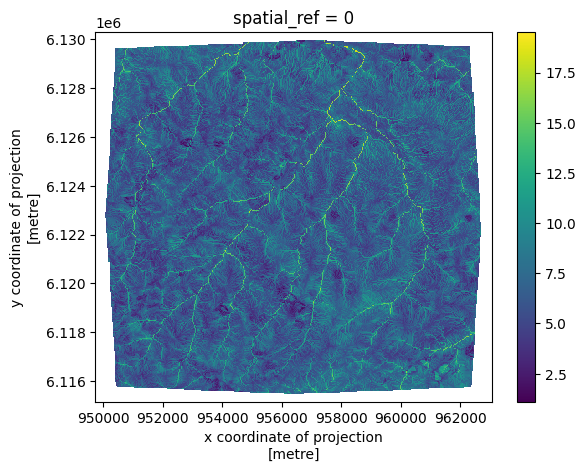

In [116]:
twi_data.plot()

In [118]:
# Convert twi_data to xarray using the same coordinates as acc_xarray_reprojected
twi_xarray = xr.DataArray(
    twi_data,
    coords=acc_xarray_reprojected.coords,
    dims=acc_xarray_reprojected.dims,
    attrs={
        "crs": acc_xarray_reprojected.rio.crs,
        "units": "dimensionless",
        "long_name": "Topographic Wetness Index",
        "description": "ln(flow_accumulation / tan(slope + 0.0001))",
    },
)

# Verify it worked
print(f"twi_xarray shape: {twi_xarray.shape}")
print(f"twi_xarray CRS: {twi_xarray.rio.crs}")

twi_xarray shape: (538, 474)
twi_xarray CRS: EPSG:32720


In [120]:
twi_xarray.rio.to_raster("/home/nissim/Documents/dev/ciut-inundaciones/data/twi.tif")

In [ ]:
# first, make sure I have flow accumulation and slope in the same format, CRS, and resolution
# make sure slope is calculated in radians
# add a small constant of 0.0001 to slope
# then calculate TWI as ln(flow_accumulation / tan(slope))
# then visualize